In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastprogress import progress_bar
import pickle 

import torch
import torch.nn.functional as F
from torch.distributions import constraints
from torch.optim import lr_scheduler

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.optim import Adam, ClippedAdam, PyroOptim, SGD
from pyro.infer.autoguide import AutoDiagonalNormal, AutoGuideList
from pyro import poutine
from torch.optim.lr_scheduler import StepLR

In [3]:
regions = pickle.load(open('test/luad34.regions.entropies.pkl', 'rb'))
regions.sort_values(by='log2_corrected', ascending=False, inplace=True)
df = regions[regions.chrom != 19]
data = torch.tensor(df['log2_corrected'].values, dtype=torch.float32)
N = data.shape[0]

In [ ]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

def train(num_iterations):
    pyro.clear_param_store()
    pb = progress_bar(range(num_iterations))
    for j in pb:
        loss = svi.step(data)
        losses.append(loss)
        if j % 10 == 0:
            if loss is not None:
                pb.comment = f"Iteration {j}: Loss = {loss:.2f}"

def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", Normal(0, 0.05))
        
    with pyro.plate("sigma_plate", T):
        sigma = pyro.sample("sigma", Gamma(1.5, 0.2))
        
    with pyro.plate("df_plate", T):
        df = pyro.sample("df", Gamma(3, 1))

    with pyro.plate("data", N, subsample_size=subsample_size) as ind:
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", StudentT(df[z], mu[z], sigma[z]), obs=data[ind])
        # pyro.sample("obs", Normal(mu[z], sigma[z]), obs=subset)


def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 5).sample([T-1]), constraint=constraints.positive)
    global_mean = data.mean()
    mu_init = torch.linspace(global_mean - 0.01, global_mean + 0.01, T)
    mu_param = pyro.param('mu_param', mu_init)
    sigma_init = data.std() * torch.ones(T) 
    sigma_param = pyro.param('sigma_param', sigma_init, constraint=constraints.positive)
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)
    df_param = pyro.param('df_param', lambda: LogNormal(1, 0.5).sample([T]), constraint=constraints.positive)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))
    
    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", Normal(mu_param, 1.))
    
    with pyro.plate("sigma_plate", T):
        q_sigma = pyro.sample("sigma", LogNormal(sigma_param, 0.5))

    with pyro.plate("df_plate", T):
        q_df = pyro.sample("df", LogNormal(df_param, 0.5))

    with pyro.plate("data", N, subsample_size=subsample_size) as ind:
        subset = data[ind]
        z = pyro.sample("z", Categorical(phi[ind]))

T = 5
alpha = 0.1
N = len(data)
n_iter = 1000
subsample_size = 10_000
initial_lr = 1e-2
gamma = 0.1
lrd = gamma ** (1 / n_iter)
optim = Adam({'lr': initial_lr, 'lrd': lrd})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

train(n_iter)

samples = torch.linspace(-0.3, 0.3, 300)

mu_optimal = pyro.param("mu_param").detach()
sigma_optimal = pyro.param("sigma_param").detach()
kappa_optimal = pyro.param("kappa").detach()
df_optimal = pyro.param("df_param").detach()

Bayes_Weights = mix_weights(1. / (1. + kappa_optimal))

def mixture_of_t(weights, mu, sigma, df, samples):
    return (weights * StudentT(df, mu, sigma).log_prob(samples.unsqueeze(-1)).exp()).sum(-1)

def mixture_of_normals(weights, mu, sigma, samples):
    return (weights * Normal(mu, sigma).log_prob(samples.unsqueeze(-1)).exp()).sum(-1)

# likelihood = mixture_of_normals(Bayes_Weights, mu_optimal, sigma_optimal, samples)

likelihood = mixture_of_t(Bayes_Weights, mu_optimal, sigma_optimal, df_optimal, samples)

plt.figure(figsize=(20, 10))
plt.title("Data vs. Estimated Mixture Density")
plt.hist(data.numpy(), bins=2000, density=True, lw=0, alpha=0.75) 
plt.plot(samples, likelihood, label="Estimated Mixture Density")
plt.xlim(-.5, .5)
plt.legend()
plt.show()


In [ ]:
df = regions[regions.chrom != 19]
df.sort_values(by='log2_corrected', ascending=False, inplace=True)
df.reset_index(inplace=True)
plt.figure(figsize=(20, 10))
plt.scatter(df.index, df['log2_corrected'], s=0.5)

n: 0.9701664447784424
s: 0.5325353741645813
phi: 2.309722661972046


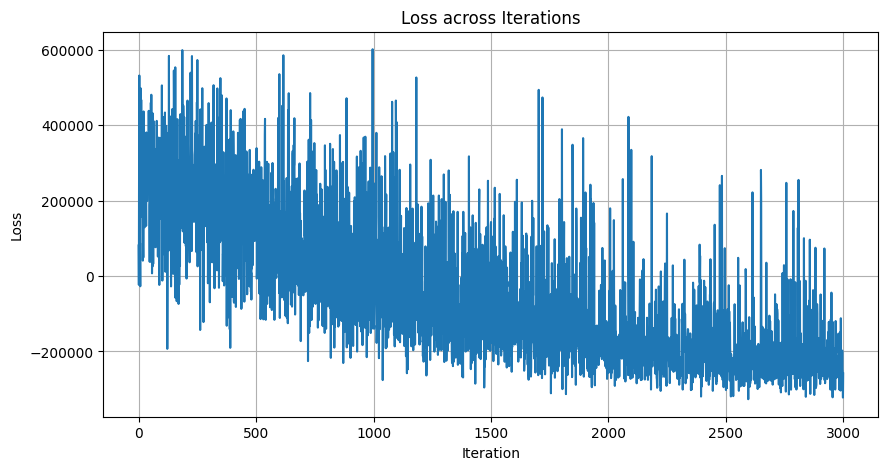

,clonal,subclonal,weights,nu,mu
16,2,3,1.595440,6.832117,8.964137e-05
18,3,3,1.561798,6.719443,1.125272e-04
7,2,2,1.416855,6.248467,4.506010e-05
9,3,2,1.360037,5.783004,6.794699e-05
15,4,2,1.291479,5.886527,9.095256e-05
3,3,4,1.260839,5.980186,1.571055e-04
10,5,2,1.248139,6.004081,1.138384e-04
1,1,2,1.215475,5.383226,2.205347e-05
4,4,3,1.207721,5.867420,1.354126e-04
11,4,4,1.190414,6.450848,1.799898e-04


In [6]:
def train(num_iterations):
    pyro.clear_param_store()
    pb = progress_bar(range(num_iterations))
    for j in pb:
        loss = svi.step(data)
        losses.append(loss)
        if j % 10 == 0:
            if loss is not None:
                pb.comment = f"Iteration {j}: Loss = {loss:.2f}"


def get_mu():
    predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1)
    samples = predictive(data)
    return samples["mu"].squeeze()


def dirichlet_prior(states, target_state=torch.tensor([2,2]), sigma=1.0):
    distances = torch.norm(states - target_state, dim=1)
    return torch.exp(-distances**2 / (2*sigma**2))


def model(data):

    weights = pyro.sample("weights", Dirichlet(dirichlet_prior(states)))

    n = pyro.sample("n", Beta(20.0, 2.0))
    
    s = pyro.sample("s", Beta(2.0, 20.0))
    
    phi = pyro.sample("phi", Gamma(1, 0.1))

    mu = pyro.deterministic("mu", torch.log((2 * n + (1 - n) * ((1 - s) * states[:, 0] + s * states[:, 1])) / (2 * n + (1 - n) * phi)))

    with pyro.plate("states", n_states):
        nu = pyro.sample("nu", Gamma(1, 0.1))
        scale = pyro.sample("scale", Gamma(1, 0.1))

    with pyro.plate("data", len(data), subsample_size=subsample_size) as ind:
        pyro.sample("obs", MixtureSameFamily(Categorical(weights), StudentT(nu, mu, scale)), obs=data[ind])


def guide(data):

    alpha_q = pyro.param("alpha_q", torch.ones(n_states), constraint=constraints.positive)
    pyro.sample("weights", Dirichlet(alpha_q))
    
    alpha_n = pyro.param("alpha_n", torch.tensor(1.), constraint=constraints.positive)
    beta_n = pyro.param("beta_n", torch.tensor(1.), constraint=constraints.positive)
    pyro.sample("n", Beta(alpha_n, beta_n))

    alpha_s = pyro.param("alpha_s", torch.tensor(1.), constraint=constraints.positive)
    beta_s = pyro.param("beta_s", torch.tensor(1.), constraint=constraints.positive)
    pyro.sample("s", Beta(alpha_s, beta_s))

    alpha_phi = pyro.param("alpha_phi", torch.tensor(3.), constraint=constraints.positive)
    beta_phi = pyro.param("beta_phi", torch.tensor(1.), constraint=constraints.positive)
    pyro.sample("phi", Gamma(alpha_phi, beta_phi))
    
    with pyro.plate("states", n_states):
        alpha_nu = pyro.param("alpha_nu", torch.ones(n_states), constraint=constraints.positive)
        beta_nu = pyro.param("beta_nu", torch.ones(n_states), constraint=constraints.positive)
        pyro.sample("nu", Gamma(alpha_nu, beta_nu))

        alpha_scale = pyro.param("alpha_scale", torch.ones(n_states), constraint=constraints.positive)
        beta_scale = pyro.param("beta_scale", torch.ones(n_states), constraint=constraints.positive)
        pyro.sample("scale", Gamma(alpha_scale, beta_scale))
        

clonal = 6
states_set = {(c, c-1) for c in range(1, clonal)} | \
        {(c, c) for c in range(clonal)} | \
        {(c, c+1) for c in range(clonal)} | \
        {(c, 2) for c in range(clonal)}
states_df = pd.DataFrame(states_set, columns=['clonal', 'subclonal'])
states = torch.tensor(states_df.values, dtype=torch.float32)
n_states = len(states)

data = torch.tensor(df['log2_corrected'].values, dtype=torch.float32)
N = data.shape[0]
n_iter = 3000
subsample_size = N #int(N / 8)
initial_lr = 1e-3
gamma = 0.01
lrd = gamma ** (1 / n_iter)
optim = Adam({'lr': initial_lr, 'betas': (0.95, 0.999)})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

train(n_iter)

states_df['weights'] = pyro.param("alpha_q").detach()
states_df['nu'] = pyro.param("alpha_nu").detach() / pyro.param("beta_nu").detach()
states_df['mu'] = get_mu().detach()
states_df.sort_values(by='weights', ascending=False, inplace=True)

n_optimal = pyro.param("alpha_n").detach() / (pyro.param("alpha_n").detach() + pyro.param("beta_n").detach())
s_optimal = pyro.param("alpha_s").detach() / (pyro.param("alpha_s").detach() + pyro.param("beta_s").detach())
phi_optimal = pyro.param("alpha_phi").detach() / pyro.param("beta_phi").detach()

print(f"n: {n_optimal}")
print(f"s: {s_optimal}")
print(f"phi: {phi_optimal}")

def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Loss across Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss(losses)
states_df


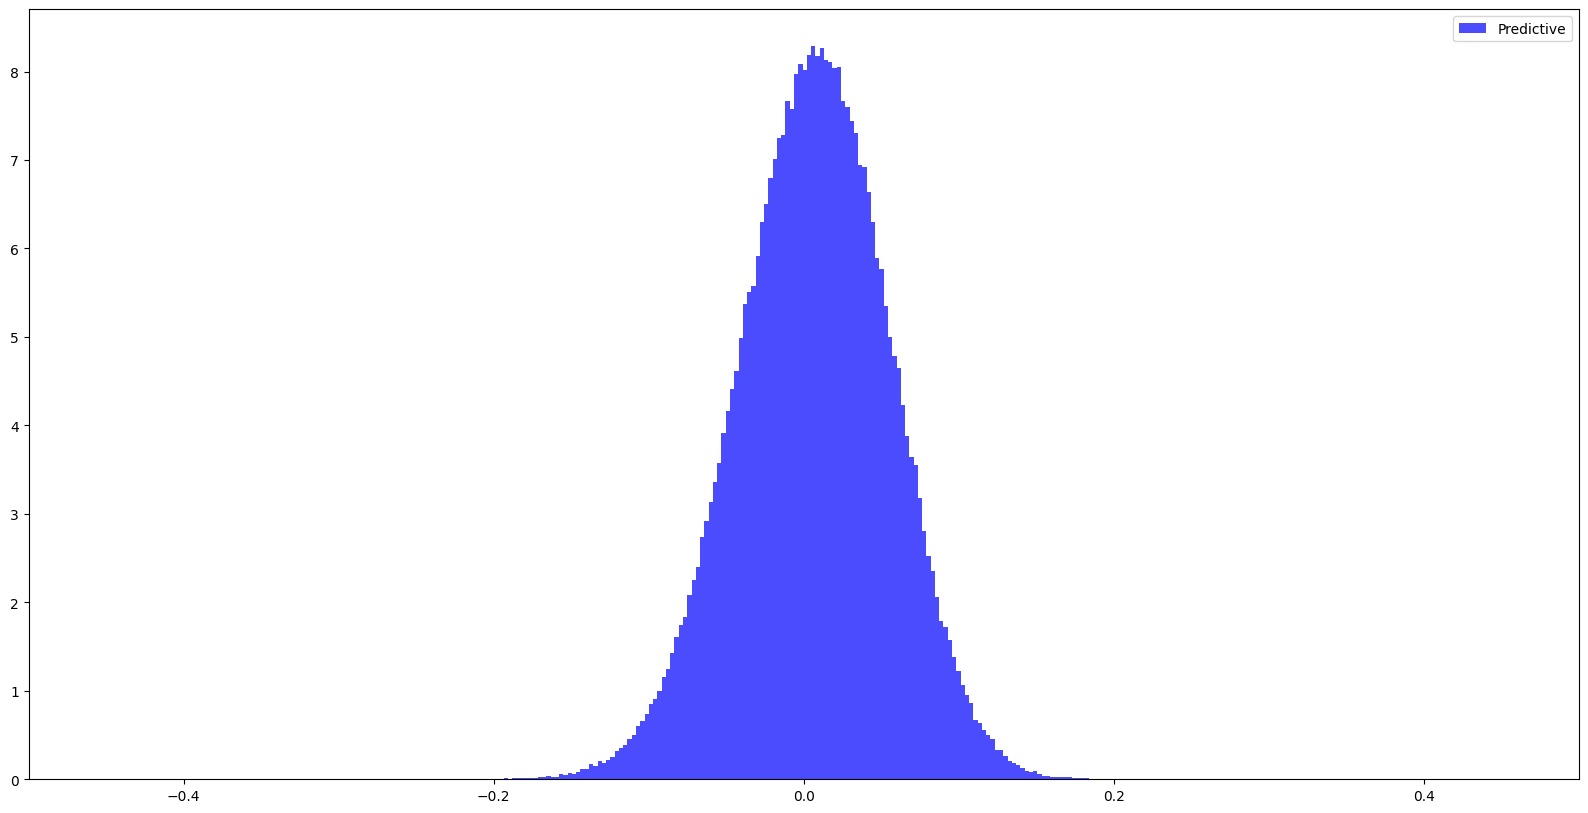

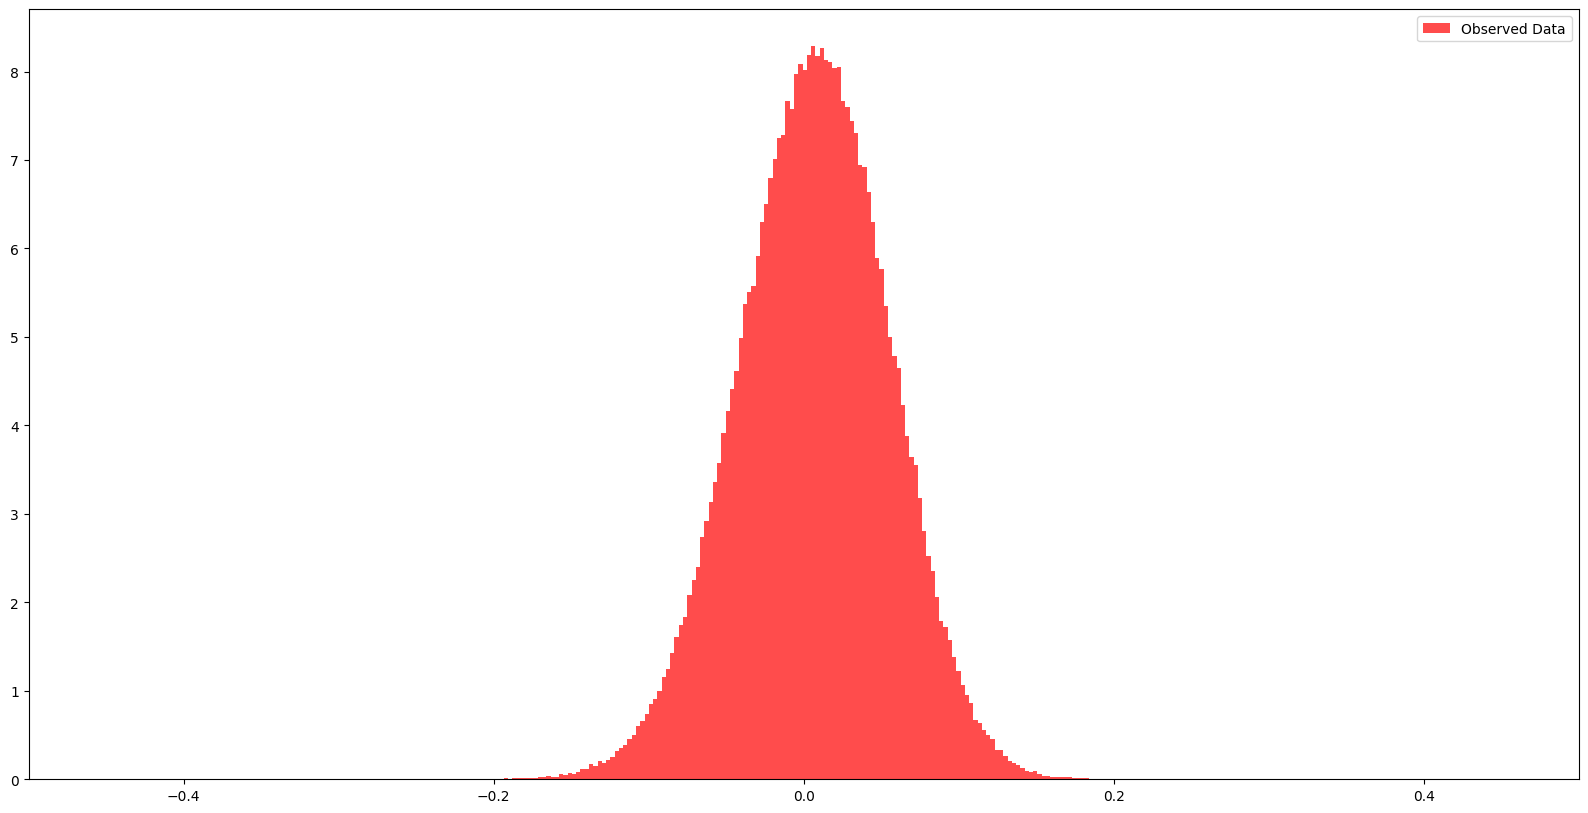

In [7]:
predictive = Predictive(model, guide=guide, num_samples=1000)
plt.figure(figsize=(20, 10))

plt.hist(predictive(data)["obs"].detach().numpy().flatten(), bins=1000, density=True, alpha=0.7, label='Predictive', color='blue')
plt.xlim(-.5, .5)
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.hist(data.numpy(), bins=1000, density=True, alpha=0.7, label='Observed Data', color='red')

plt.xlim(-.5, .5)
plt.legend()
plt.show()


In [43]:
import arviz as az
import xarray as xr

def pyro_to_arviz(samples):
    # Convert samples to xarray dataset
    data = {k: xr.DataArray(v, dims=["chain", "draw"]) for k, v in samples.items()}
    dataset = xr.Dataset(data)
    return az.from_xarray(dataset)
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000)
samples = predictive(data)
samples
# posterior = pyro_to_arviz(samples)
# # Posterior plot
# az.plot_posterior(posterior)

# # Trace plot
# az.plot_trace(posterior)

# # And many other visualizations...


ValueError: cannot reindex or align along dimension 'draw' because of conflicting dimension sizes: {1, 20, 60175}